This was the final submission for the competition:

https://datahack.analyticsvidhya.com/contest/ltfs-datascience-finhack-an-online-hackathon/

It resulted in the following RoC AuC:
- 0.67419 in CV
- 0.654437993218256 in Public LB 
- 0.6614491739 in Private LB

Private LB rank was 159 and Public LB rank was 221 (out of 1343 participants) : Top 12% on private leader board.

https://datahack.analyticsvidhya.com/contest/ltfs-datascience-finhack-an-online-hackathon/pvt_lb

In [20]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta, date

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


warnings.filterwarnings('ignore')

from eli5.permutation_importance import get_score_importances

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [21]:
DATA_DIR = '/data1/arnab/k/ltfs/data'

In [22]:
train = pd.read_csv(f'{DATA_DIR}/train.csv', sep=',', parse_dates=False, low_memory=False)
test = pd.read_csv(f'{DATA_DIR}/test.csv', sep=',', parse_dates=False, low_memory=False)
submission = pd.read_csv(f'{DATA_DIR}/sample_submission.csv', sep=',')

print(f'Shape of train {train.shape}')
print(f'Shape of train {test.shape}')
print(f'Shape of train {submission.shape}')

Shape of train (233154, 41)
Shape of train (112392, 40)
Shape of train (112392, 2)


In [4]:
def flatten_column_names(df, existing_string, replace_string):
    '''
    1. Converts the column names to lower case
    2. Replace space or dot with underscrore
    
    Example usage : train = flatten_column_names(train, '.', '_')
    '''
    # Convert the column names to lower case
    df.columns = [name.lower() for name in df.columns]
    # Replace space or dot with underscrore
    df.columns = [name.replace(existing_string, replace_string) for name in df.columns]
    return df


def handle_y2k(df, feature_name, after_year):
    '''
    Handles Y2K issue : Pandas is mapping years between 00 & 68 as 2000-2068.
    But, based on the use case, it might have to be mapped between years 1900 & 1968.
    https://stackoverflow.com/questions/37766353/pandas-to-datetime-parsing-wrong-year
    
    feature_name : feature where this conversion is necessary
    after_year : Integer. Eg. 2020 or 2050 etc
    
    Example Usage: Any number XX after 20 will be considered as 19XX. 
    21 will be converted into 1921.
    
    train = handle_y2k(train, 'date_of_birth', 2020)
    
    '''
    df[feature_name] = pd.to_datetime(df[feature_name], format='%d-%m-%y')
    future = df[feature_name] > date(year=after_year, month=1, day=1)
    df.loc[future, feature_name] -= timedelta(days=365.25*100)
    
    return df


def convert_todatetime(df, feature_name, datetime_format):
    '''
    Converts a string into datetime of specified format
    
    train['disbursaldate'] = convert_todatetime(train, 'disbursaldate', '%d-%m-%y')
    '''
    return pd.to_datetime(df[feature_name], format=datetime_format)


def plot_lgbm_importnace(model, importance_type, column_names):
    '''
    Plot feature importance derived from LGBM. Also returns the importance vs feature
    in a DF.
    
    Example usage:
    
    clf = LGBMClassifier(n_jobs=8, random_state=42)
    clf.fit(train_X, train_y)
    
    lgbm_importance_split_df = plot_lgbm_importnace(clf, 'split', train_X.columns)
    
    '''
    lgbm_importance = model.booster_.feature_importance(importance_type=importance_type)

    feats = {} 
    for feature, importance in zip(column_names, lgbm_importance):
        feats[feature] = importance

    lgbm_importance_df = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
    lgbm_importance_df.sort_values(by='Importance').plot.barh(figsize=(8, 12))
    plt.show()
    
    return lgbm_importance_df


def create_date_features(df, feature_name, d=True, m=True, y=True, q=True, w=True):
    '''
    Create date related features
    Example Usage: 
    '''
    df_new = pd.DataFrame(index=df.index)
    if d:
        df_new[f'{feature_name}_date'] = df[feature_name].dt.day
    if m:
        df_new[f'{feature_name}_month'] = df[feature_name].dt.month
    if y:
        df_new[f'{feature_name}_year'] = df[feature_name].dt.year
    if q:
        df_new[f'{feature_name}_quarter'] = df[feature_name].dt.quarter
    if w:
        df_new[f'{feature_name}_week'] = df[feature_name].dt.week
    return df_new

def do_frequency_encoding(df, feature_name):
    '''
    Create frequency encoding of the feature
    '''
    encoding = df.groupby(feature_name).size()/len(df)
    return df[feature_name].map(encoding)

def do_label_encoding(df, feature_name):
    '''
    Create label encoding of the feature
    '''
    label_encoder = LabelEncoder()
    return label_encoder.fit_transform(df[feature_name])

In [5]:
# Flatten column names
train = flatten_column_names(train, '.', '_')
test = flatten_column_names(test, '.', '_')

# Handle date_of_birth column
train = handle_y2k(train, 'date_of_birth', 2020)
test = handle_y2k(test, 'date_of_birth', 2020)

# Handle disbursaldate column
train['disbursaldate'] = convert_todatetime(train, 'disbursaldate', '%d-%m-%y')
test['disbursaldate'] = convert_todatetime(test, 'disbursaldate', '%d-%m-%y')

### Combine and create features

In [6]:
train.sort_values(by='disbursaldate', inplace=True)
train.reset_index(drop=True, inplace=True)

test.sort_values(by='disbursaldate', inplace=True)
test.reset_index(drop=True, inplace=True)

# Get the ids for train and test
train_ids = train.uniqueid.values
test_ids = test.uniqueid.values

# Length of the train data
train_index = train.shape[0]
print(f'train_index : {train_index}')

y_name = 'loan_default'
combined_df = pd.concat([train.drop(y_name, axis=1), test])
# Train and Test has duplicate indices
combined_df.reset_index(drop=True, inplace=True)
print(f'Expected Shape {train.shape[0] + test.shape[0]}')
print(f'Actual Shape {combined_df.shape[0]}')

train_index : 233154
Expected Shape 345546
Actual Shape 345546


### Clean up the existing features & create new features

In [7]:
# Create a new category 'Not Employed'
combined_df.employment_type.fillna('Not Employed', inplace=True)

# Convert average_acct_age in months
tmp = combined_df['average_acct_age'].str.split(' ', expand=True)
combined_df['average_acct_age_years'] = tmp[0].str.split('yrs', expand=True)[0].astype(int)
combined_df['average_acct_age_months'] = tmp[1].str.split('mon', expand=True)[0].astype(int)
combined_df['average_acct_age_years_months'] = tmp[0].str.split('yrs', expand=True)[0].astype(int) * 12 + tmp[1].str.split('mon', expand=True)[0].astype(int)

# Convert 'credit_history_length' in months
tmp = combined_df['credit_history_length'].str.split(' ', expand=True)
combined_df['credit_history_length_years'] = tmp[0].str.split('yrs', expand=True)[0].astype(int)
combined_df['credit_history_length_months'] = tmp[1].str.split('mon', expand=True)[0].astype(int)
combined_df['credit_history_length_years_months'] = tmp[0].str.split('yrs', expand=True)[0].astype(int) * 12 + tmp[1].str.split('mon', expand=True)[0].astype(int)

## New Features

In [8]:
print(f'Shape before new features {combined_df.shape}')

# Create new feature age_during_disbursal
combined_df['age_during_disbursal'] = combined_df.disbursaldate.dt.year - combined_df.date_of_birth.dt.year

# Add date features for date of birth
combined_df = pd.concat([combined_df, create_date_features(combined_df, 'date_of_birth')], axis=1)

# Add date features for date of birth
combined_df = pd.concat([combined_df, create_date_features(combined_df, 'disbursaldate', d=True, m=False, y=False, w=True, q=False)], axis=1)

combined_df['is_any_national_id_available'] = (combined_df.aadhar_flag | combined_df.pan_flag | combined_df.voterid_flag | combined_df.passport_flag)

combined_df['branch_to_state_id'] = combined_df.state_id.astype('str')+'-'+combined_df.branch_id.astype('str')
combined_df['supplier_to_state_id'] = combined_df.state_id.astype('str')+'-'+combined_df.supplier_id.astype('str')
combined_df['manufacturer_to_state_id'] = combined_df.state_id.astype('str')+'-'+combined_df.manufacturer_id.astype('str')
combined_df['branch_employee_id'] = combined_df.branch_id.astype(str) + '-' + combined_df.employee_code_id.astype(str)

combined_df['branch_to_state_id_le'] = do_label_encoding(combined_df, 'branch_to_state_id')
combined_df['supplier_to_state_id_le'] = do_label_encoding(combined_df, 'supplier_to_state_id')
combined_df['manufacturer_to_state_id_le'] = do_label_encoding(combined_df, 'manufacturer_to_state_id')
combined_df['branch_employee_id_le'] = do_label_encoding(combined_df, 'branch_employee_id')
combined_df['current_pincode_id_le'] = do_label_encoding(combined_df, 'current_pincode_id')
combined_df['employment_type_le'] = do_label_encoding(combined_df, 'employment_type')

combined_df['branch_to_state_id_fe'] = do_frequency_encoding(combined_df, 'branch_to_state_id')
combined_df['employment_type_fe'] = do_frequency_encoding(combined_df, 'employment_type')
combined_df['state_id_fe'] = do_frequency_encoding(combined_df, 'state_id')
combined_df['perform_cns_score_description_fe'] = do_frequency_encoding(combined_df, 'perform_cns_score_description')

cns_score_map = {'No Bureau History Available':100, 'Not Scored: More than 50 active Accounts found':101
                 , 'Not Scored: Only a Guarantor':102, 'Not Scored: Sufficient History Not Available':103
                 , 'Not Scored: No Activity seen on the customer (Inactive)':104
                 , 'Not Scored: Not Enough Info available on the customer':105
                 , 'Not Scored: No Updates available in last 36 months':106
                 , 'M-Very High Risk':1, 'L-Very High Risk':2, 'K-High Risk':3
                 , 'J-High Risk':4, 'I-Medium Risk':5, 'H-Medium Risk':6
                 , 'G-Low Risk':7, 'F-Low Risk':8, 'E-Low Risk':9
                 , 'D-Very Low Risk':10, 'C-Very Low Risk':11, 'B-Very Low Risk':12
                 , 'A-Very Low Risk' : 13}

# perform_cns_score_description : Map String to an integer 
combined_df['perform_cns_score_description_ordinal_mapping'] = combined_df.replace(
    {'perform_cns_score_description' : cns_score_map})['perform_cns_score_description']

combined_df.drop(['branch_to_state_id', 'supplier_to_state_id', 'manufacturer_to_state_id', 'branch_employee_id'], axis=1, inplace=True)

print(f'Shape after new features {combined_df.shape}')

########## Features related to Primary Account #######################

# Primary Number of accounts closed
combined_df['pri_no_of_accts_closed'] = np.where(
    (combined_df.pri_no_of_accts == 0), 0, (combined_df.pri_no_of_accts - combined_df.pri_active_accts))

# Fraction of primary number of accounts closed
combined_df['frac_pri_no_of_accts_closed'] = np.where(
    (combined_df.pri_no_of_accts == 0), 0, (combined_df.pri_no_of_accts - combined_df.pri_active_accts)/combined_df.pri_no_of_accts)

# Fraction of primary number of accounts active
combined_df['frac_pri_no_of_accts_active'] = np.where(
    (combined_df.pri_no_of_accts == 0), 0, (combined_df.pri_active_accts/combined_df.pri_no_of_accts))

# Fraction of the primary accounts deafulted
combined_df['frac_pri_overdue_accts'] = np.where(
    (combined_df.pri_no_of_accts == 0), 0, (combined_df.pri_overdue_accts/combined_df.pri_no_of_accts))

########## Features related to Total Account #######################

# Combine primary and secondary numebr of accounts
combined_df['total_no_of_accts'] = combined_df.pri_no_of_accts + combined_df.sec_no_of_accts
combined_df['total_active_accts'] = combined_df.pri_active_accts + combined_df.sec_active_accts
combined_df['total_overdue_accts'] = combined_df.pri_overdue_accts + combined_df.sec_overdue_accts

# Total Number of accounts closed
combined_df['total_no_of_accts_closed'] = np.where(
    (combined_df.total_no_of_accts == 0), 0, (combined_df.total_no_of_accts - combined_df.total_active_accts))

# Fraction of Total number of accounts closed
combined_df['frac_total_no_of_accts_closed'] = np.where(
    (combined_df.total_no_of_accts == 0), 0, (combined_df.total_no_of_accts - combined_df.total_active_accts)/combined_df.total_no_of_accts)

# Fraction of Total number of accounts active
combined_df['frac_total_no_of_accts_active'] = np.where(
    (combined_df.total_no_of_accts == 0), 0, (combined_df.total_active_accts/combined_df.total_no_of_accts))

# Fraction of the Total accounts deafulted
combined_df['frac_total_overdue_accts'] = np.where(
    (combined_df.total_no_of_accts == 0), 0, (combined_df.total_overdue_accts/combined_df.total_no_of_accts))

########## Features related to Secondary Account #######################

# Secondray Number of accounts closed
combined_df['sec_no_of_accts_closed'] = np.where(
    (combined_df.sec_no_of_accts == 0), 0, (combined_df.sec_no_of_accts - combined_df.sec_active_accts))

# Fraction of Secondray number of accounts closed
combined_df['frac_sec_no_of_accts_closed'] = np.where(
    (combined_df.sec_no_of_accts == 0), 0, (combined_df.sec_no_of_accts - combined_df.sec_active_accts)/combined_df.sec_no_of_accts)

# Fraction of Secondray number of accounts active
combined_df['frac_sec_no_of_accts_active'] = np.where(
    (combined_df.sec_no_of_accts == 0), 0, (combined_df.sec_active_accts/combined_df.sec_no_of_accts))

# Fraction of the Secondray accounts deafulted
combined_df['frac_sec_overdue_accts'] = np.where(
    (combined_df.sec_no_of_accts == 0), 0, (combined_df.sec_overdue_accts/combined_df.sec_no_of_accts))


############## Information about last six months ############################

# Fraction of new accounts in last six months
combined_df['frac_new_accts_in_last_six_months'] = np.where(
    (combined_df.total_no_of_accts ==0), 0, combined_df.new_accts_in_last_six_months/combined_df.total_no_of_accts)

# Fraction of defaulted accounts in last six months
combined_df['frac_delinquent_accts_in_last_six_months'] = np.where(
    (combined_df.total_overdue_accts ==0), 0, combined_df.delinquent_accts_in_last_six_months/combined_df.total_overdue_accts)

############### Total balance related features ############################

combined_df['total_current_balance'] = combined_df.pri_current_balance + combined_df.sec_current_balance
combined_df['total_sanctioned_amount'] = combined_df.pri_sanctioned_amount + combined_df.sec_sanctioned_amount
combined_df['total_disbursed_amount'] = combined_df.pri_disbursed_amount + combined_df.sec_disbursed_amount

combined_df['pri_downpayment_amount'] = combined_df.pri_sanctioned_amount - combined_df.pri_disbursed_amount
combined_df['sec_downpayment_amount'] = combined_df.sec_sanctioned_amount - combined_df.sec_disbursed_amount
combined_df['total_downpayment_amount'] = combined_df.total_sanctioned_amount - combined_df.total_disbursed_amount


# Create a set of features indicating that the borrowers account balance is running negative
combined_df['neg_pri_current_balance'] = np.where(combined_df.pri_current_balance < 0, 1, 0)
combined_df['neg_sec_current_balance'] = np.where(combined_df.sec_current_balance < 0, 1, 0)
#combined_df['neg_pri_sanctioned_amount'] = np.where(combined_df.pri_sanctioned_amount < 0, 1, 0)

# Number of enqueries per loan
combined_df['no_of_enqueries_per_loan'] = np.where(((combined_df.no_of_inquiries == 0) | (combined_df.pri_no_of_accts ==0)) 
                                                   , 0, combined_df.no_of_inquiries / combined_df.pri_no_of_accts)
# Number of enqueries per month
combined_df['no_of_enqueries_per_year'] = np.where(((combined_df.no_of_inquiries == 0) | (combined_df.credit_history_length ==0)) 
                                                   , 0, (combined_df.no_of_inquiries / combined_df.credit_history_length_years_months)*12)

####################### Is the person already have a huge loan (home loan?) ============================
combined_df['total_current_balance_avg'] = np.where((combined_df.total_no_of_accts == 0), 0, combined_df.total_current_balance/combined_df.total_no_of_accts)
combined_df['pri_current_balance_avg'] = np.where((combined_df.pri_no_of_accts == 0), 0, combined_df.pri_current_balance/combined_df.pri_no_of_accts)
combined_df['sec_current_balance_avg'] = np.where((combined_df.sec_no_of_accts == 0), 0, combined_df.sec_current_balance/combined_df.sec_no_of_accts)

##################################### Instalment amount #####################################
combined_df['total_instal_amount'] = combined_df.primary_instal_amt + combined_df.sec_instal_amt

combined_df['primary_instal_amt_avg'] = np.where((combined_df.pri_no_of_accts == 0), 0, combined_df.primary_instal_amt / combined_df.pri_no_of_accts)
combined_df['sec_instal_amt_avg'] = np.where((combined_df.sec_no_of_accts == 0), 0, combined_df.sec_instal_amt / combined_df.sec_no_of_accts)
combined_df['total_instal_amt_avg'] = np.where((combined_df.total_no_of_accts == 0), 0, combined_df.total_instal_amount / combined_df.total_no_of_accts)

# Number of accounts defaulted per year
combined_df['total_overdue_acct_per_year'] = np.where((combined_df.average_acct_age_years_months == 0)
                                                      , 0, (combined_df.total_overdue_accts/combined_df.average_acct_age_years_months)*12)

# Not sure what this feature actually mean?
combined_df['acct_age_to_credit_history'] = np.where((combined_df.average_acct_age_years_months == 0), 0, combined_df.credit_history_length_years_months/combined_df.average_acct_age_years_months)

# Whether unusual number of accounts were opened in last six months
combined_df['avg_loans_increased_in_six_months'] = np.where((combined_df.credit_history_length_years_months == 0)
                                                            , 0, (combined_df.new_accts_in_last_six_months 
                                                                  - ((combined_df.total_no_of_accts/combined_df.credit_history_length_years_months)*6)))

# Whether unusual number of accounts were defaulted in last six months
combined_df['default_loans_increased_in_six_months'] = np.where((combined_df.credit_history_length_years_months == 0)
                                                            , 0, (combined_df.delinquent_accts_in_last_six_months 
                                                                  - ((combined_df.total_overdue_accts/combined_df.credit_history_length_years_months)*6)))

Shape before new features (345546, 46)
Shape after new features (345546, 66)


In [9]:
#independent_vars = combined_df.columns.tolist()
dependent_var = y_name
print(dependent_var)

loan_default


In [10]:
list_to_exclude = ['uniqueid', 'date_of_birth', 'disbursaldate',  'state_id',  
     'branch_id', 'branch_to_state_id', 'branch_to_state_id_le',
     'supplier_id', 'supplier_to_state_id', 
     'manufacturer_id','manufacturer_to_state_id', 
     'employee_code_id', 'branch_employee_id',
     'employment_type', 'employment_type_le',  
     'perform_cns_score_description', 'perform_cns_score_description_ordinal_mapping', 
     'average_acct_age', 'credit_history_length', 
     'current_pincode_id',
    'frac_sec_no_of_accts_active',
    'frac_sec_overdue_accts',
    'sec_disbursed_amount',
    'sec_active_accts',
    'frac_sec_no_of_accts_closed',
    'sec_no_of_accts_closed',
    'date_of_birth_quarter',
    'sec_downpayment_amount',
    'passport_flag',
    'neg_pri_current_balance',
    'neg_sec_current_balance',
    'sec_overdue_accts',
    'driving_flag',
    'mobileno_avl_flag',
    #'acct_age_to_credit_history', # Performance Degraded
    'default_loans_increased_in_six_months']

print(f'Shape combined_df {combined_df.shape}')
df_org = combined_df.iloc[:, ~combined_df.columns.isin(list_to_exclude)]
print(df_org.shape)
print(f'Shape df_org {df_org.shape}')

train_X = df_org.iloc[:train_index,:]
print(f'train_X {train_X.shape}')

test_X = df_org.iloc[train_index:, :]
print(f'test_X {test_X.shape}')

train_y = train['loan_default']
print(f'train_y {train_y.shape}')

Shape combined_df (345546, 104)
(345546, 73)
Shape df_org (345546, 73)
train_X (233154, 73)
test_X (112392, 73)
train_y (233154,)


In [11]:
cat_params = {'learning_rate': 0.02,
              'depth': 5,
              'l2_leaf_reg': 10,
              'bootstrap_type': 'Bernoulli',
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 50,
              'allow_writing_files': False,
              'random_state':42}

# Build the model now
NFOLDS = 10
print('Initializing StratifiedKFold with {} folds..'.format(NFOLDS))
RANDOM_STATE = 42

clfs = []
folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=RANDOM_STATE)
oof_preds = np.zeros((len(train), 1))
test_preds = np.zeros((len(test), 1))
roc_cv =[]

print('Training...')
for fold_, (trn_, val_) in enumerate(folds.split(train_y, train_y)):
    print("Current Fold: {}".format(fold_))
    trn_x, trn_y = train_X.loc[trn_, :], train_y.loc[trn_]
    val_x, val_y = train_X.loc[val_, :], train_y.loc[val_]
    
    clf = CatBoostClassifier(iterations=4000, eval_metric='AUC', **cat_params)

    clf.fit(trn_x, trn_y, eval_set=(val_x, val_y), cat_features=[], use_best_model=True, verbose=200)

    val_pred = clf.predict_proba(val_x)[:,1]
    test_fold_pred = clf.predict_proba(test_X)[:,1]
    
    roc_cv.append(roc_auc_score(val_y, val_pred))

    print("AUC = {}".format(roc_auc_score(val_y, val_pred)))
    #print(val_)
    #print(val_pred.reshape((-1, 1)))
    oof_preds[val_, :] = val_pred.reshape((-1, 1))
    test_preds += test_fold_pred.reshape((-1, 1))

test_preds /= NFOLDS

roc_score_1 = round(roc_auc_score(train_y, oof_preds.ravel()), 5)
roc_score = round(sum(roc_cv)/len(roc_cv), 5)
st_dev = round(np.array(roc_cv).std(), 5)

print("Average of the folds' ROC AUCs = {}".format(roc_score))
print("Combined folds' (created from OOF) AUC = {}".format(roc_score_1))
print("The standard deviation = {}".format(st_dev))

Initializing StratifiedKFold with 10 folds..
Training...
Current Fold: 0
0:	test: 0.5715021	best: 0.5715021 (0)	total: 99.3ms	remaining: 6m 37s
200:	test: 0.6515359	best: 0.6515359 (200)	total: 8.1s	remaining: 2m 33s
400:	test: 0.6597269	best: 0.6597269 (400)	total: 16s	remaining: 2m 24s
600:	test: 0.6642675	best: 0.6642675 (600)	total: 24s	remaining: 2m 15s
800:	test: 0.6679067	best: 0.6679067 (800)	total: 31.9s	remaining: 2m 7s
1000:	test: 0.6701811	best: 0.6701811 (1000)	total: 40.1s	remaining: 2m
1200:	test: 0.6715731	best: 0.6715731 (1200)	total: 47.9s	remaining: 1m 51s
1400:	test: 0.6725408	best: 0.6725408 (1400)	total: 55.8s	remaining: 1m 43s
1600:	test: 0.6733091	best: 0.6733091 (1600)	total: 1m 3s	remaining: 1m 35s
1800:	test: 0.6740357	best: 0.6740395 (1799)	total: 1m 11s	remaining: 1m 27s
2000:	test: 0.6746289	best: 0.6746332 (1999)	total: 1m 19s	remaining: 1m 19s
2200:	test: 0.6749986	best: 0.6749986 (2200)	total: 1m 27s	remaining: 1m 11s
2400:	test: 0.6754369	best: 0.67544

In [12]:
results_df = pd.DataFrame(index=combined_df.iloc[train_index:, :].uniqueid)
results_df['loan_default'] = test_preds.astype(float)
results_df.reset_index(inplace=True)
results_df.columns=['UniqueID', 'loan_default']

In [13]:
final_submission = pd.merge(submission, results_df, how='left', on='UniqueID')
final_submission.drop(['loan_default_x'], axis=1, inplace=True)
final_submission.columns = ['UniqueID', 'loan_default']

In [14]:
# Prepare the submission file
print("Saving submission file")
final_submission.to_csv('cat_submission_24.csv', index=False)

Saving submission file


## Check feature importance

In [18]:
clf = CatBoostClassifier(iterations=4000, eval_metric='AUC', **cat_params)
clf.fit(train_X, train_y)

0:	total: 40.4ms	remaining: 2m 41s
1:	total: 74.9ms	remaining: 2m 29s
2:	total: 106ms	remaining: 2m 21s
3:	total: 137ms	remaining: 2m 16s
4:	total: 168ms	remaining: 2m 13s
5:	total: 202ms	remaining: 2m 14s
6:	total: 245ms	remaining: 2m 19s
7:	total: 278ms	remaining: 2m 18s
8:	total: 310ms	remaining: 2m 17s
9:	total: 345ms	remaining: 2m 17s
10:	total: 376ms	remaining: 2m 16s
11:	total: 412ms	remaining: 2m 16s
12:	total: 451ms	remaining: 2m 18s
13:	total: 483ms	remaining: 2m 17s
14:	total: 519ms	remaining: 2m 17s
15:	total: 551ms	remaining: 2m 17s
16:	total: 584ms	remaining: 2m 16s
17:	total: 620ms	remaining: 2m 17s
18:	total: 662ms	remaining: 2m 18s
19:	total: 696ms	remaining: 2m 18s
20:	total: 734ms	remaining: 2m 18s
21:	total: 775ms	remaining: 2m 20s
22:	total: 812ms	remaining: 2m 20s
23:	total: 848ms	remaining: 2m 20s
24:	total: 887ms	remaining: 2m 21s
25:	total: 922ms	remaining: 2m 20s
26:	total: 959ms	remaining: 2m 21s
27:	total: 996ms	remaining: 2m 21s
28:	total: 1.03s	remaining: 

In [ ]:
%%time
def score(X, y):
    y_pred = clf.predict_proba(X)[:,1]
    return roc_auc_score(y, y_pred)

base_score, score_decreases = get_score_importances(score, train_X.values, train_y.values, random_state=42)
feature_importances = np.mean(score_decreases, axis=0)

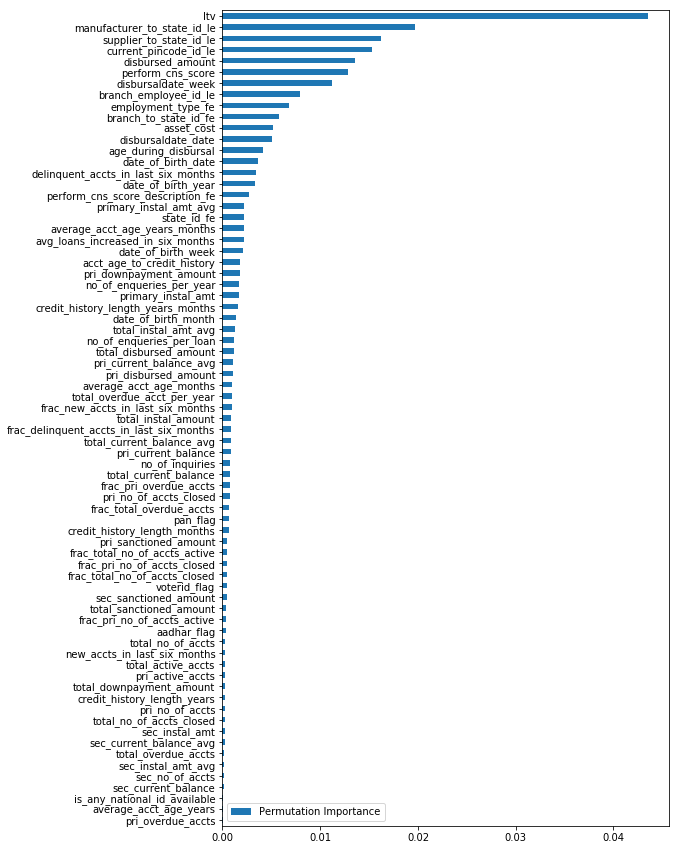

In [23]:
feats = {} 
for feature, importance in zip(train_X.columns, feature_importances):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Permutation Importance'})
importances.sort_values(by='Permutation Importance').plot.barh(figsize=(8, 15))

In [25]:
importances.sort_values(by='Permutation Importance', ascending=False)

,Permutation Importance
ltv,0.043489
manufacturer_to_state_id_le,0.019723
supplier_to_state_id_le,0.016266
current_pincode_id_le,0.015315
disbursed_amount,0.013573
perform_cns_score,0.012819
disbursaldate_week,0.011198
branch_employee_id_le,0.007964
employment_type_fe,0.006801
branch_to_state_id_fe,0.005793
